# 交叉验证

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# 用于在jupyter中进行绘图
%matplotlib inline

## 水果识别

### 1. 数据加载

In [142]:
# 加载数据集
fruits_df = pd.read_table('fruit_data_with_colors.txt')
fruits_df.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [143]:
print('样本个数：', len(fruits_df))

样本个数： 59


In [144]:
# 创建目标标签和名称的字典
fruit_name_dict = dict(zip(fruits_df['fruit_label'], fruits_df['fruit_name']))
print(fruit_name_dict)

{1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}


In [145]:
# 划分数据集
X = fruits_df[['mass', 'width', 'height', 'color_score']]
y = fruits_df['fruit_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

In [146]:
print('数据集样本数：{}，训练集样本数：{}，测试集样本数：{}'.format(len(X), len(X_train), len(X_test)))

数据集样本数：59，训练集样本数：44，测试集样本数：15


### 2. 特征归一化

In [147]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for i in range(4):
    print('归一化前，训练数据第{}维特征最大值：{:.3f}，最小值：{:.3f}'.format(i + 1, 
                                           X_train.iloc[:, i].max(), 
                                           X_train.iloc[:, i].min()))
    print('归一化后，训练数据第{}维特征最大值：{:.3f}，最小值：{:.3f}'.format(i + 1, 
                                           X_train_scaled[:, i].max(), 
                                           X_train_scaled[:, i].min()))
    print()

归一化前，训练数据第1维特征最大值：356.000，最小值：76.000
归一化后，训练数据第1维特征最大值：1.000，最小值：0.000

归一化前，训练数据第2维特征最大值：9.200，最小值：5.800
归一化后，训练数据第2维特征最大值：1.000，最小值：0.000

归一化前，训练数据第3维特征最大值：10.500，最小值：4.000
归一化后，训练数据第3维特征最大值：1.000，最小值：0.000

归一化前，训练数据第4维特征最大值：0.920，最小值：0.550
归一化后，训练数据第4维特征最大值：1.000，最小值：0.000



### 3. 交叉验证

#### 3.1 单一超参数

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_range = [5, 10, 15, 20]
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=3)
    cv_score = np.mean(scores)
    print('k={}，验证集上的准确率={:.3f}'.format(k, cv_score))
    cv_scores.append(cv_score)

k=5，验证集上的准确率=0.845
k=10，验证集上的准确率=0.495
k=15，验证集上的准确率=0.521
k=20，验证集上的准确率=0.546


In [83]:
best_k = k_range[np.argmax(cv_scores)]
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)
print('测试集准确率：', best_knn.score(X_test_scaled, y_test))

测试集准确率： 1.0


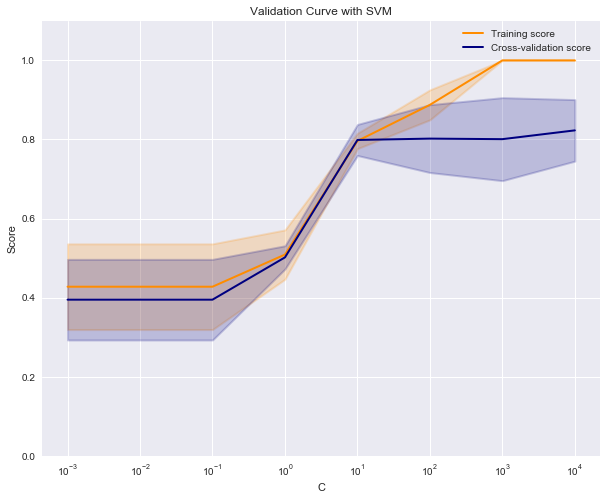

In [51]:
# 调用  validation_curve 绘制超参数对训练集和验证集的影响
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
c_range = [1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000]
train_scores, test_scores = validation_curve(SVC(), X_train_scaled, y_train, 
                                             param_name='C', param_range=c_range,
                                             cv=3, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.title('Validation Curve with SVM')
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(c_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(c_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(c_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(c_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [56]:
# 从上图可知对SVM，C=10, 100为最优参数
svm_model = SVC(C=100)
svm_model.fit(X_train_scaled, y_train)
print(svm_model.score(X_test_scaled, y_test))

0.866666666667


#### 3.2 多个超参数

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth':[3, 5, 7, 9], 'min_samples_leaf': [1, 2, 3, 4]}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [76]:
print('最优参数：', clf.best_params_)
print('验证集最高得分：', clf.best_score_)

最优参数： {'max_depth': 5, 'min_samples_leaf': 1}
验证集最高得分： 0.75


In [77]:
# 获取最优模型
best_model = clf.best_estimator_
print('测试集上准确率：', best_model.score(X_test, y_test))

测试集上准确率： 0.933333333333


# 模型评价指标

In [138]:
k = 7
# 转换为二分类问题
y_train_binary = y_train.copy()
y_test_binary = y_test.copy()

y_train_binary[y_train_binary != 1] = 0
y_test_binary[y_test_binary != 1] = 0

knn = KNeighborsClassifier(k)
knn.fit(X_train_scaled, y_train_binary)
y_pred = knn.predict(X_test_scaled)

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 准确率
print('准确率：{:.3f}'.format(accuracy_score(y_test_binary, y_pred)))

# 精确率
print('精确率：{:.3f}'.format(precision_score(y_test_binary, y_pred)))

# 召回率
print('召回率：{:.3f}'.format(recall_score(y_test_binary, y_pred)))

# F1值
print('F1值：{:.3f}'.format(f1_score(y_test_binary, y_pred)))

准确率：0.933
精确率：0.800
召回率：1.000
F1值：0.889


## PR 曲线

[PR曲线的绘制](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [140]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AP值：{:.3f}'.format(average_precision_score(y_test_binary, y_pred)))

AP值：0.800


## ROC曲线

[ROC曲线的绘制](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html)

In [141]:
from sklearn.metrics import roc_auc_score, roc_curve

# fpr, tpr, _ = roc_curve(y_test, y_pred)
print('AUC值：{:.3f}'.format(roc_auc_score(y_test_binary, y_pred)))

AUC值：0.955


## 混淆矩阵

[混淆矩阵的绘制](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [160]:
from sklearn.metrics import confusion_matrix

y_pred = svm_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4 0 0 0]
 [0 1 0 0]
 [2 0 6 0]
 [0 0 0 2]]


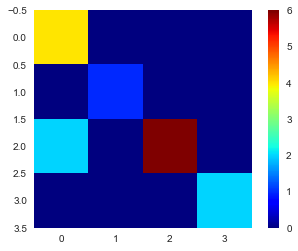

In [167]:
plt.figure()
plt.grid(False)
plt.imshow(cm, cmap='jet')
plt.colorbar()